# Chocolate Rating Analysis

# Web scraping data to then process, clean, etc. in the notebook.

In [1]:
# import warnings
# warnings.filterwarnings('ignore')

# from requests import get
# from bs4 import BeautifulSoup
# import pandas as pd
# from selenium import webdriver
# import chromedriver_autoinstaller
# def create_driver(headless=True):
#     driver = chromedriver_autoinstaller.install(cwd=True)
#     chrome_options = webdriver.ChromeOptions()     
#     if headless:
#         chrome_options.add_argument("--headless")
#     driver = webdriver.Chrome(driver, 
#                              chrome_options = chrome_options)
#     return driver
# driver = create_driver()

In [2]:
# driver.get("http://flavorsofcacao.com/chocolate_database.html")

In [3]:
# div_id = "spryregion1"

# html = driver.page_source
# soup = BeautifulSoup(html)
# div = soup.find('div', {'id':div_id})
# # div

# table = div.find('table')
# table


In [4]:
# pd.read_html(str(table))[0]

In [5]:
# df.to_csv('../../../data/chocolate.csv', index=False)

# Importing Necessary Python Libraries 

In [6]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import plot_confusion_matrix, auc, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE

all_data = pd.read_csv('../../../data/chocolate.csv')
all_data.head()

,REF,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,797,A. Morin,France,2012,Peru,Peru,63%,"4- B,S,C,L","fruity, melon, roasty",3.75
4,797,A. Morin,France,2012,Bolivia,Bolivia,70%,"4- B,S,C,L","vegetal, nutty",3.50


# Data Cleaning 

### Replacing column spaces with underscores and lower casing column names for simplicity when calling them. 

In [7]:
#breaking away from original dataset and creating a copy to maintain the original structure as "all_data"
df = all_data.copy()

In [8]:
#removing parenthesis and spaces from columns 
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.lower()

#removing percent signs from row cocoa_percent
df = df.replace("%", "", regex=True)
# turning percentage of cocoa into a float
df["cocoa_percent"] = df.cocoa_percent.astype(float)

df.head()

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,797,A. Morin,France,2012,Peru,Peru,63.0,"4- B,S,C,L","fruity, melon, roasty",3.75
4,797,A. Morin,France,2012,Bolivia,Bolivia,70.0,"4- B,S,C,L","vegetal, nutty",3.50


# Exploratory Data Analysis: 
Determining the goals for the features in terms of which to compare to the target variable and the take aways for each feaure

## Looking into the relationships of chocolate characteristics, company manufacturer and company location. 

### Evaluating the most memorable characteristics 

In [9]:
# over 2300 combinations of flavors 
df.most_memorable_characteristics.value_counts().sum()

2362

In [10]:
df.most_memorable_characteristics.value_counts()

spicy, cocoa                 4
creamy, nutty, cocoa         4
sweet, vanilla, cocoa        3
sandy, sweet, cocoa          3
cherry, rich choco           3
                            ..
vegetable and honey          1
woody, nutty, short          1
dried fruit, cocoa           1
intense plum, harsh woody    1
dry, chalky, fudge-like      1
Name: most_memorable_characteristics, Length: 2320, dtype: int64

In [11]:
from collections import Counter

* could break up flavors individually and determine which flavors occured most in the chocolate bars 

In [12]:
word_list = [word.strip().replace(',', '').replace('"', '') for word in " ".join(df.most_memorable_characteristics).split()]
word_counts = np.unique(word_list, return_counts=True)
word_c = np.array([word_counts[0], word_counts[1]])
word_df = pd.DataFrame(word_c.T, columns=['word', 'count'])
word_df.sort_values(by='count', ascending=False)

,word,count
360,molasses,90
564,toffee,9
159,cream,9
89,buttery,9
282,hazelnut,9
...,...,...
385,noticeable,1
51,berrypowerful,1
155,cooling,1
382,not,1


In [13]:
char = Counter(" ".join(df.most_memorable_characteristics).split()).most_common(25)
char

[('sweet,', 213),
 ('cocoa', 199),
 ('mild', 198),
 ('creamy,', 174),
 ('nutty,', 163),
 ('cocoa,', 157),
 ('sandy,', 154),
 ('fruit,', 140),
 ('sour', 127),
 ('fatty,', 123),
 ('roasty,', 117),
 ('intense,', 112),
 ('floral,', 108),
 ('earthy,', 105),
 ('spicy,', 103),
 ('rich', 97),
 ('nutty', 97),
 ('fruit', 96),
 ('off', 94),
 ('roasty', 93),
 ('earthy', 80),
 ('sweet', 74),
 ('sticky,', 71),
 ('vanilla,', 67),
 ('dried', 67)]

In [14]:
count = 0
for c in df.most_memorable_characteristics.values:
    if 'sweet' in [x.strip().replace(',', '').replace('"', '') for x in c.split(', ')]:
        count += 1
count

248

In [15]:
word_count_list = Counter(word_list).most_common(25)
word_count_list

[('cocoa', 356),
 ('sweet', 287),
 ('nutty', 260),
 ('fruit', 236),
 ('roasty', 210),
 ('mild', 208),
 ('sour', 185),
 ('earthy', 185),
 ('creamy', 183),
 ('intense', 166),
 ('sandy', 161),
 ('fatty', 157),
 ('floral', 150),
 ('spicy', 144),
 ('rich', 141),
 ('bitter', 120),
 ('off', 104),
 ('vanilla', 101),
 ('molasses', 90),
 ('coffee', 87),
 ('woody', 85),
 ('spice', 79),
 ('sticky', 78),
 ('berry', 72),
 ('tart', 70)]

In [16]:
x = [count_list[0] for count_list in word_count_list]
y = [count_list[1] for count_list in word_count_list]

In [17]:
# df['individual_chars'] = df
x

['cocoa',
 'sweet',
 'nutty',
 'fruit',
 'roasty',
 'mild',
 'sour',
 'earthy',
 'creamy',
 'intense',
 'sandy',
 'fatty',
 'floral',
 'spicy',
 'rich',
 'bitter',
 'off',
 'vanilla',
 'molasses',
 'coffee',
 'woody',
 'spice',
 'sticky',
 'berry',
 'tart']

- Loop through words in `x`


- Filter dataframe where that word is in most memorable characteristics (split and clean words)


`x.strip().replace(',', '').replace('"', '') for x in c.split(', ')`

- Calculate average rating for filtered dataframe
- Save as key-value pair in dictionary



In [24]:
cleaned_word_list = []
for char in df['most_memorable_characteristics'].values:
    l = char.split(', ')
    clean_list = [word.replace(',', '').replace('"', '').strip() for word in l] 
    cleaned_word_list.append(clean_list)

In [26]:
df['memorable_characteristics_list'] = cleaned_word_list

In [28]:
df[df['memorable_characteristics_list'].apply(lambda lst: x[0] in lst)]

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,memorable_characteristics_list
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"[cocoa, blackberry, full body]"
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,"[cocoa, vegetal, savory]"
6,1019,A. Morin,France,2013,Peru,Chanchamayo Province,63.0,"3- B,S,C","sweet, cocoa, tangerine",4.00,"[sweet, cocoa, tangerine]"
7,1011,A. Morin,France,2013,Ecuador,Equateur,70.0,"4- B,S,C,L","sandy, nutty, cocoa, fig",3.75,"[sandy, nutty, cocoa, fig]"
11,1019,A. Morin,France,2013,Peru,Piura,70.0,"4- B,S,C,L","green, nutty, cocoa",3.25,"[green, nutty, cocoa]"
...,...,...,...,...,...,...,...,...,...,...,...
2267,153,Vintage Plantations (Tulicorp),U.S.A.,2007,Ecuador,"Los Rios, Rancho Grande 2007",65.0,"3- B,S,C","sticky, cocoa, earthy",3.00,"[sticky, cocoa, earthy]"
2274,1502,Violet Sky,U.S.A.,2015,Guatemala,Cahabon,77.0,"2- B,S","creamy, cocoa, pungent",2.75,"[creamy, cocoa, pungent]"
2275,1724,Vivra,U.S.A.,2016,Dominican Republic,Dominican Republic,70.0,"5- B,S,C,V,L","sweet, simple, cocoa",3.00,"[sweet, simple, cocoa]"
2293,593,Willie's Cacao,U.K.,2010,Venezuela,Hacienda Las Trincheras,72.0,"3- B,S,C","dry, nutty, cocoa",3.50,"[dry, nutty, cocoa]"


In [40]:
num_rows = df.shape[0]
num_rows

2362

In [41]:
#creating a for loop using isin method 
weighted_chars = {}
for word in x:
    #the df[df is returning the values associated with the list comprehension - lambda rather than a boolean
    word_df = df[df['memorable_characteristics_list'].apply(lambda lst: word in lst)]
    avg_rating = word_df['rating'].mean()
    weight = len(word_df) / num_rows
    weighted_chars[word] = avg_rating * weight 
    
#split on the existing words 
#average the new data 
#saving as key-val pairs

In [54]:
weighted_chars

{'cocoa': 0.30450889077053345,
 'sweet': 0.3197502116850127,
 'nutty': 0.3386960203217612,
 'fruit': 0.10605419136325149,
 'roasty': 0.27180355630821335,
 'mild': 0.015664690939881456,
 'sour': 0.1561176968670618,
 'earthy': 0.22629127857747672,
 'creamy': 0.26926333615580017,
 'intense': 0.17506350550381033,
 'sandy': 0.20745131244707876,
 'fatty': 0.19856054191363254,
 'floral': 0.18844199830651992,
 'spicy': 0.18480101608806096,
 'rich': 0.0979043183742591,
 'bitter': 0.07430143945808637,
 'off': 0.03492802709568162,
 'vanilla': 0.10160880609652838,
 'molasses': 0.10192633361558001,
 'coffee': 0.09568162574089754,
 'woody': 0.10499576629974597,
 'spice': 0.08012277730736664,
 'sticky': 0.10319644369178663,
 'berry': 0.024343776460626586,
 'tart': 0.07758255715495342}

In [64]:
weighted_chars.values()

dict_values([0.30450889077053345, 0.3197502116850127, 0.3386960203217612, 0.10605419136325149, 0.27180355630821335, 0.015664690939881456, 0.1561176968670618, 0.22629127857747672, 0.26926333615580017, 0.17506350550381033, 0.20745131244707876, 0.19856054191363254, 0.18844199830651992, 0.18480101608806096, 0.0979043183742591, 0.07430143945808637, 0.03492802709568162, 0.10160880609652838, 0.10192633361558001, 0.09568162574089754, 0.10499576629974597, 0.08012277730736664, 0.10319644369178663, 0.024343776460626586, 0.07758255715495342])

<BarContainer object of 25 artists>

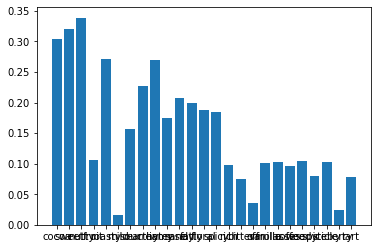

In [68]:
# Plotting the most memorable characteristics

import matplotlib.pyplot as plt

x = weighted_chars.keys()

y = weighted_chars.values()

plt.bar(x,y)

In [ ]:
# company manufacturer
x = df.most_memorable_characteristics
y = df.rating 

sns.barplot(x=x, y=y, hue=None, data=df)



In [ ]:
# company location
x = df.most_memorable_characteristics
y = df.rating 

sns.barplot(x=x, y=y, hue=None, data=df)



# Feature Engineering:

 Checking the Feauture's Relationships to Rating

### Inspecting the company location's weighted average in relation to rating

In [ ]:
# Average rating of each country. ex: 'Puerto Rico': 2.625
average_ratings_company_location = df.groupby('company_location')['rating'].mean().sort_values().to_dict()


In [ ]:
# Percentage of Country appearances. ex: 'U.S.A.': 0.42929720575783237
company_location_counts = df['company_location'].value_counts(normalize=True).to_dict()


In [ ]:
#creating a weighted average number of appearances * rating
import matplotlib.pyplot as plt
companies_loc = df.company_location.unique()


#Inspecting the weighting average of the appearance of countries and the rating 

#ex: country appearance percentage * country average rating 
weighted_rating = []
for company in companies_loc:
    count = company_location_counts[company]
    rating = average_ratings_company_location[company]
    weighted_rating.append(count * rating)
    
sorted_vals = sorted(list(zip(weighted_rating, companies_loc)))
x = [val[1] for val in sorted_vals]
y = [val[0] for val in sorted_vals]

# Creating a vizualization for the relationships
plt.figure(figsize=(15,6))
plt.bar(x, y)
plt.xticks(rotation=90);
sorted_vals

## Feature Engineering the Companies' Countries Number of Appearances by Setting them to Low / Medium / High. 

In [ ]:
#Matching the country weighted ratings with each country.
#company_loc -> unique country non-repeated 
group_df = pd.DataFrame(list(zip(companies_loc, weighted_rating)), columns=['country', 'weighted_rating'])
group_df.head()

### Using q-cut with a Value of 3

In [ ]:
group_df['weighted_company_bins'] = pd.qcut(group_df['weighted_rating'], 
                                            labels=['low', 'middle', 'high'], q=3)

In [ ]:
weighted_company_bins = group_df.set_index('country')['weighted_company_bins'].to_dict()

In [ ]:
df['company_bins'] = df['company_location'].map(weighted_company_bins)

In [ ]:
df.head(2)

### Binning the Company Location into Groups of  A / B / C

In [ ]:
first_bin = x[:47]
df['comp_location_bin'] = 1

bin_a_index = df[df.company_location.isin(first_bin)].index
df.at[bin_a_index, 'comp_location_bin'] = 'a'

In [ ]:
idx = x.index('Italy') + 1
second_bin = x[47:idx]

bin_b_index = df[df.company_location.isin(second_bin)].index
df.at[bin_b_index, 'comp_location_bin'] = 'b'



In [ ]:
idx2 = x.index('U.K.') 
third_bin = x[idx2:]

bin_c_index = df[df.company_location.isin(third_bin)].index
df.at[bin_c_index, 'comp_location_bin'] = 'c'

In [ ]:
x[idx2:]

In [ ]:
df.value_counts('comp_location_bin')

In [ ]:
df[df.comp_location_bin == 1].company_location.unique()

In [ ]:
df['company_bin'] = df['comp_location_bin']

### Binning the Company Location into Groups of  1 / 2 / 3

In [ ]:
company_bin = []
for c in df['company_location'].values:
    if c in first_bin:
        company_bin.append(1)
    elif c in second_bin:
        company_bin.append(2)
    else:
        company_bin.append(3)
        
df['company_bin'] = company_bin

In [ ]:
df['company_bin'].value_counts()

In [ ]:
df.head()

### Removing the unnecissary information leading up to the ingredient names

In [ ]:
# retreiving rows from the third index and on - leaving out rows with empty values
df['ingredient_list'] = [np.nan if l is np.nan else l[3:] for l in df['ingredients']]

### Inspecting the value (occurance count) and leaving out those with a low number of occurances

In [ ]:
df['ingredient_list'].value_counts()

In [ ]:
# leaving out occurances below 8 

most_common = (df['ingredient_list'].value_counts()).iloc[:9].index


df = df[df['ingredient_list'].isin(most_common)]


In [ ]:
#ensuring that values below 8 were removed
df.ingredient_list.value_counts()

------

### -- Only use if we BREAK UP INGREDIENTS and MOST_MEM_CHAR --  Separating multiple into their own individual rows ----

In [ ]:
#placing each ingredient into a new list sepparated by commas

# df.most_memorable_characteristics = df.most_memorable_characteristics.str.split(',')


# df['split_ingredients'] = df['ingredient_list'].str.split(',')

# df = df.explode('split_ingredients')
# df = df.explode('most_memorable_characteristics')


------------

------------

In [ ]:
df.head(2)

## Checking to see whether specific_bean_origin_or_bar_name is important or not

In [ ]:
df['specific_bean_origin_or_bar_name'].value_counts()[:50].plot(kind='bar', figsize=(15,6))

## Clarifying important predictor values (x) for the target value (y).

In [ ]:
# dropping the target (y) values from x and specific origin
features = df.drop(['rating','specific_bean_origin_or_bar_name', 'ingredients', 'review_date', 'ref'], axis =1)
X = features
y = df.rating


### Splitting the data into three subsets of training and validation data for the future models.
    Two train test splits create three subsets of the original dataset which allows for the training data to not be bled into the test data - this reduced model's bias towards the pre-existing testing data, thus assuring maximum performance on future test sets which the model has never been exposed. 

In [ ]:
#performing train test split for test set (subsets 1/3)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=.15, random_state=42)


#performing a train test split for train and validation set (subsets - 3/3)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.15, random_state=42) 

In [ ]:
#checking to ensure the shape of the columns and rows are still the same for the X and y values after the train test split.
X_tr.shape, y_tr.shape

### Replacing any existing missing values  

In [ ]:
#ingredients have 88 rows that have no imputs.
X_val.isna().sum()

In [ ]:
# the empty value replacement will be done using the most frequent fill strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns = X.columns)

X_val_imputed = pd.DataFrame(imputer.fit_transform(X_val),columns = X.columns)

In [ ]:
#ensuring that the missing values from ingredients are now filled in with the most frequent occuring value

X_val_imputed.isna().sum()

### Separating groups into numeric and catagorical data types 

In [ ]:
#taking a look at the groups data types to ensure that they are separated correctly
X_train.info()

In [ ]:
# X_train_numeric 
# X_train_cat

# X_val_numerica

## Preprocessing: